# How to predict House Prices and hopefully become a Property Tycoon in New York

I am going to clean and visualise data and build a model to predict housing prices in New York. Everything is done obviously with the aim of becoming a property tycoon - one of the most important things to know in order to achieve that is the value of a property. So without further ado, let's go for it.

# 1) Load Data and Clean it

In [1]:
# Import the modules

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

# Data Scaler
from sklearn.preprocessing import StandardScaler

# Regression
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
# Read the data
data = pd.read_csv('C:/Users/akosciansky/Desktop/Kaggle/NYC Property Sales/nyc-rolling-sales.csv')

Let's update the **BOROUGH** names first according to the instructions found on Kaggle.

In [3]:
# Renaming BOROUGHS
data['BOROUGH'][data['BOROUGH'] == 1] = 'Manhattan'
data['BOROUGH'][data['BOROUGH'] == 2] = 'Bronx'
data['BOROUGH'][data['BOROUGH'] == 3] = 'Brooklyn'
data['BOROUGH'][data['BOROUGH'] == 4] = 'Queens'
data['BOROUGH'][data['BOROUGH'] == 5] = 'Staten Island'

In [4]:
# Change the settings so that you can see all columns of the dataframe when calling df.head()
pd.set_option('display.max_columns',999)
data.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


What we can see by looking at the first few rows is that the column Unnamed: 0 is an artifact from the data load and is not needed. The column EASEMENT is completely empty and will be deleted. And there some missing Sale Prices.

**Update Data**

I have already done some prior inspection of the data and am now updating the dataset by deleting columns and changing the data type of some of the variables.

In [5]:
#EASE_MEANT is empty and can be dropped
del data['EASE-MENT']

# Unnamed: 0 is an artifact from the data load and can be deleted
del data['Unnamed: 0']

In [6]:
#SALE PRICE is object but should be numeric
data['SALE PRICE'] = pd.to_numeric(data['SALE PRICE'], errors='coerce')

#LAND and GROSS SQUARE FEET is object but should be numeric
data['LAND SQUARE FEET'] = pd.to_numeric(data['LAND SQUARE FEET'], errors='coerce')
data['GROSS SQUARE FEET']= pd.to_numeric(data['GROSS SQUARE FEET'], errors='coerce')

#SALE DATE is object but should be datetime
data['SALE DATE'] = pd.to_datetime(data['SALE DATE'], errors='coerce')

#Both TAX CLASS attributes should be categorical
data['TAX CLASS AT TIME OF SALE'] = data['TAX CLASS AT TIME OF SALE'].astype('category')
data['TAX CLASS AT PRESENT'] = data['TAX CLASS AT PRESENT'].astype('category')

After updating the data let's check if there are any duplicate values in here.

In [7]:
sum(data.duplicated(data.columns))

765

There are 765 duplicates. Let's remove them

In [8]:
#Delete the duplicates and check that it worked
data = data.drop_duplicates(data.columns, keep='last')
sum(data.duplicated(data.columns))

0

**High-Level Data Inspection and Validation**

In [9]:
# Check the number of rows and columns
data.shape

(83783, 20)

In [10]:
# Get a high-level overview of the data types, the amount of NULL values etc.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83783 entries, 0 to 84547
Data columns (total 20 columns):
BOROUGH                           83783 non-null object
NEIGHBORHOOD                      83783 non-null object
BUILDING CLASS CATEGORY           83783 non-null object
TAX CLASS AT PRESENT              83783 non-null category
BLOCK                             83783 non-null int64
LOT                               83783 non-null int64
BUILDING CLASS AT PRESENT         83783 non-null object
ADDRESS                           83783 non-null object
APARTMENT NUMBER                  83783 non-null object
ZIP CODE                          83783 non-null int64
RESIDENTIAL UNITS                 83783 non-null int64
COMMERCIAL UNITS                  83783 non-null int64
TOTAL UNITS                       83783 non-null int64
LAND SQUARE FEET                  57729 non-null float64
GROSS SQUARE FEET                 56398 non-null float64
YEAR BUILT                        83783 non-null int6

Let's show this visually. It's easier that way to see where the NULL values are and how many there are.

In [11]:
# Capture the necessary data
variables = data.columns

count = []

for variable in variables:
    length = data[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(data), 2)

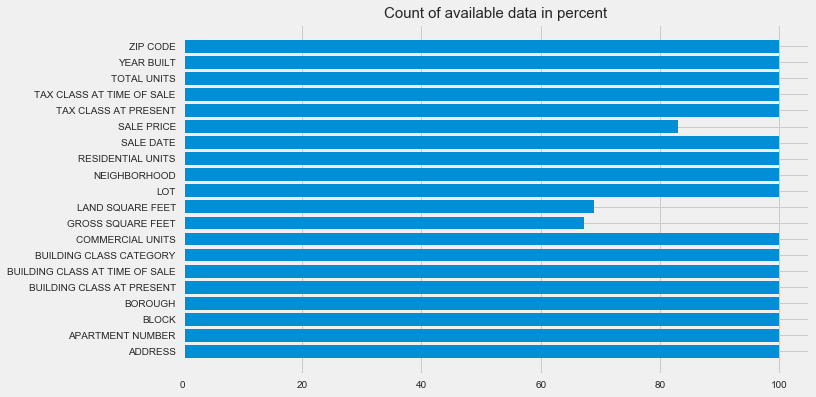

In [12]:
#Plot number of available data per variable
plt.figure(figsize=(10,6))
plt.barh(variables, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

That's a shame. 20% of all Sale Prices are NULL, which is what I wanted to predict. I could still predict a price for those cases but there is no way of verifying the accuracy of the predictions. Those observations will have to be deleted.

There are also around a third of all observations with missing Square Feet data. There is potential to impute those values but we will have to see how well that will work.

In [13]:
# Remove observations with missing SALE PRICE
data = data[data['SALE PRICE'].notnull()]
len(data)

69607

After removing the missing SALE PRICES we are left with 70k observations, down from 85k at the very start. 

Now, let's get an overview of some descriptive stats of the numerical variables in the data set.

In [14]:
data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,4.844900e+04,4.790000e+04,69607.000000,6.960700e+04
mean,4199.890140,374.580473,10741.159323,1.875070,0.164121,2.059319,3.544802e+03,3.528707e+03,1799.852184,1.280703e+06
std,3431.897518,656.232024,1264.804508,14.291398,8.997236,16.992716,3.973875e+04,2.920564e+04,520.099311,1.143036e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1350.000000,22.000000,10306.000000,0.000000,0.000000,0.000000,1.425000e+03,8.160000e+02,1920.000000,2.300000e+05
50%,3378.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.150000e+03,1.620000e+03,1938.000000,5.330000e+05
75%,6192.000000,820.000000,11249.000000,2.000000,0.000000,2.000000,3.100000e+03,2.508000e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


Some interesting observations to note:

1) There are **ZIP CODES** with a value of 0, which is probably wrong.

2) 75% of properties have no **COMMERCIAL UNITS**

3) At least 50% of all properties have only 1 **TOTAL UNIT**. I am not quite sure what to make of that yet.

4) There are properties have 0 **SQUARE FEET**, which shouldn't be possible unless they don't exist yet or the data is wrong.

5) Some buildings were built in the **YEAR** 0, which again is wrong.

6) Some properties have a **SALE PRICE** of 0, which is also wrong or a transfer but not actually a sale.

# 2) Data Inspection

Again, I have already done some data inspection and I will not show those variables that aren't useful for the model. I will first look at the dependent variable **SALE PRICE**, which is the one I want to predict. After that I will look at the independent variables, which are the ones I use to predict the price.

## 2.1) Dependent Variable Inspection 

**SALE PRICE**

Let's start with the dependent variable as this is the one I want to predict. First, some plots.

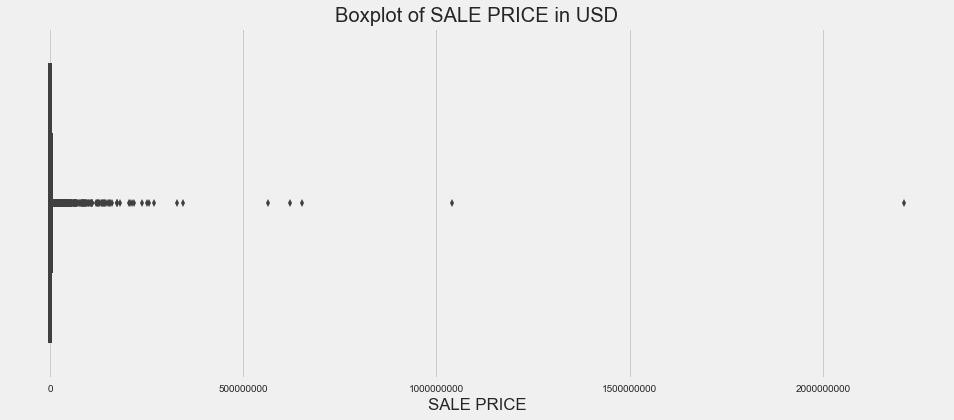

In [15]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

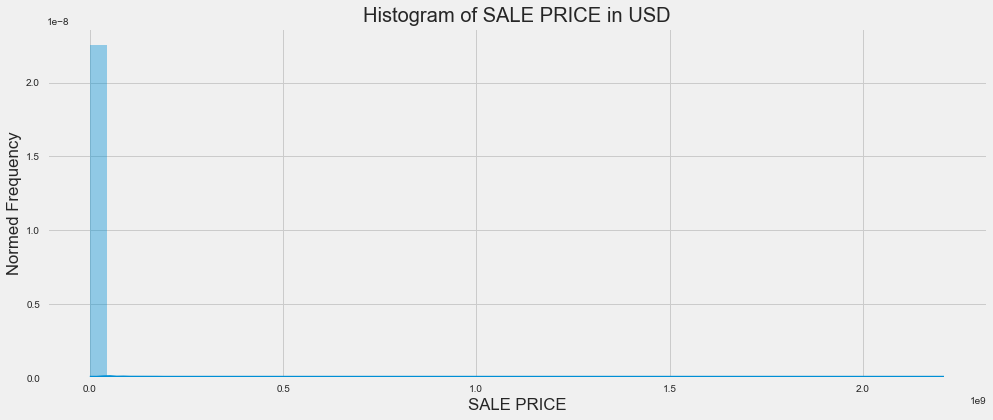

In [16]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.distplot(data['SALE PRICE'])
plt.title('Histogram of SALE PRICE in USD')
plt.ylabel('Normed Frequency')
plt.show()

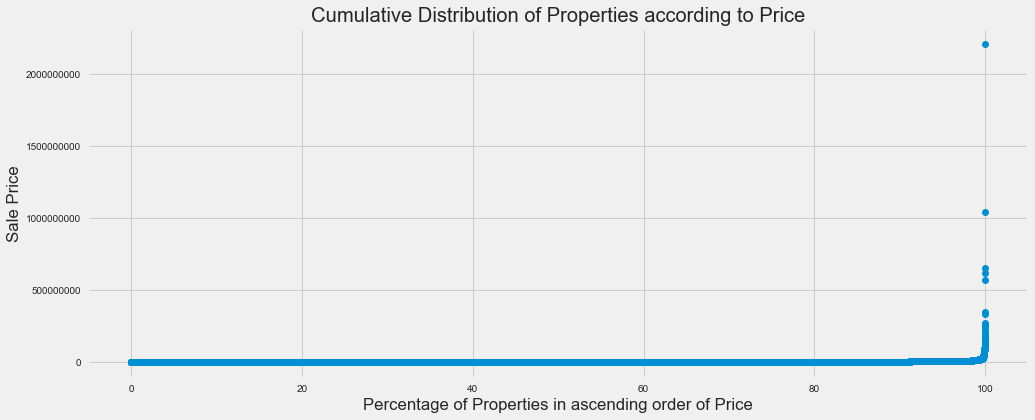

In [17]:
#Set the size of the plot
plt.figure(figsize=(15,6))

#Get the data and format it
x = data[['SALE PRICE']].sort_values(by='SALE PRICE').reset_index()
x['PROPERTY PROPORTION'] = 1
x['PROPERTY PROPORTION'] = x['PROPERTY PROPORTION'].cumsum()
x['PROPERTY PROPORTION'] = 100* x['PROPERTY PROPORTION'] / len(x['PROPERTY PROPORTION'])

# Plot the data and configure the settings
plt.plot(x['PROPERTY PROPORTION'],x['SALE PRICE'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Properties according to Price')
plt.xlabel('Percentage of Properties in ascending order of Price')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

What we see from the two graphs above is that there are a lot of outliers. Maybe this isn't all that surprising given that Manhattan is home to a lot of very expensive property. From the descriptive statistics we could also tell that 75% of the properties in this dataset are cheaper than 950,000 USD. There are also a fair number of properties cheaper than 100,000 USD, which seems too cheap in my opinion.

I have done a few iterations of what a good cap on sales prices is and settled for 

1) property needs to be more expensive than 100,000 USD

2) property needs to be cheaper than 5,000,000 USD

Everything is else is a different animal and mixing all together in one model will decrease accuracy.

In [18]:
# Remove observations that fall outside those caps
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]
len(data)

54579

And we're down from 70k observations to 55k, which is 79% remaining. That's a fair chunk of data. I've been toying with the idea of clustering properties on their SALE PRICE classifiying them as something like 'cheap', 'normal', 'expensive', and 'luxury' in order to avoid this issue. I will work on this in a future iteration.

Anyways, let's check out the same graphs again.

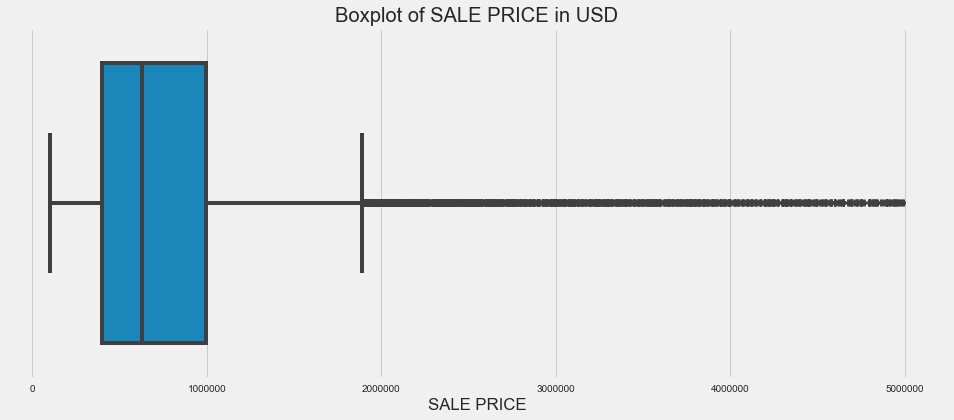

In [19]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

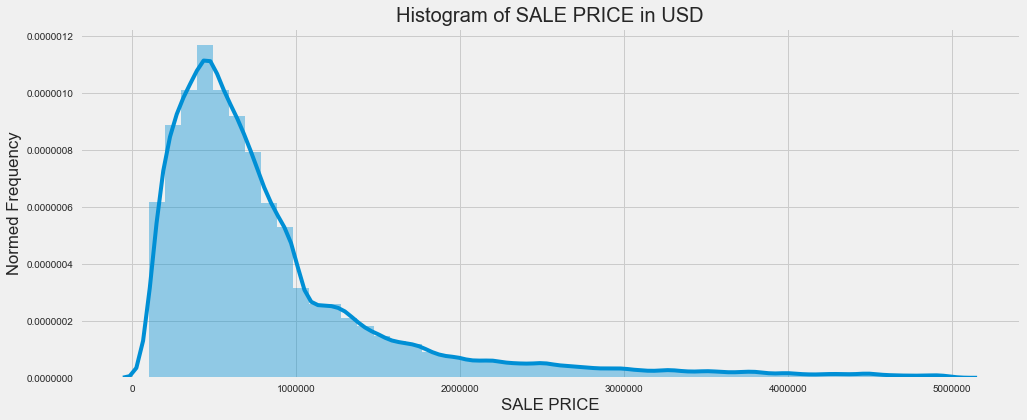

In [20]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data and configure the settings
sns.distplot(data['SALE PRICE'])
plt.title('Histogram of SALE PRICE in USD')
plt.ylabel('Normed Frequency')
plt.show()

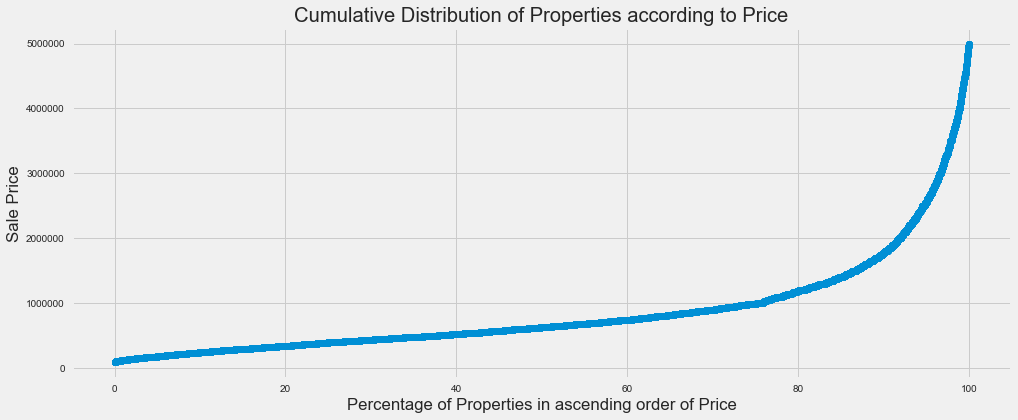

In [21]:
#Set the size of the plot
plt.figure(figsize=(15,6))

#Get the data and format it
x = data[['SALE PRICE']].sort_values(by='SALE PRICE').reset_index()
x['PROPERTY PROPORTION'] = 1
x['PROPERTY PROPORTION'] = x['PROPERTY PROPORTION'].cumsum()
x['PROPERTY PROPORTION'] = 100* x['PROPERTY PROPORTION'] / len(x['PROPERTY PROPORTION'])

# Plot the data and configure the settings
plt.plot(x['PROPERTY PROPORTION'],x['SALE PRICE'], linestyle='None', marker='o')
plt.title('Cumulative Distribution of Properties according to Price')
plt.xlabel('Percentage of Properties in ascending order of Price')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Recap and Revisit of Entire Data Set**

After I've removed some observations due to their prices, which I have treated as outliers, how many NULL **SQUARE FEET** observations remain?

Unfortunately, there are still a third of observations remaining that contain no **SQAURE FEET** data. It turns out - **SPOILER ALERT!** that this is the best predictor of **SALE PRICE** in this dataset, which means I want to keep as much data as possible instead of just throwing them away. I'll show the importance of **SQAURE FEET** in the result section at the end of the workbook.

In [22]:
# Capture the necessary data
variables = data.columns

count = []

for variable in variables:
    length = data[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(data), 2)

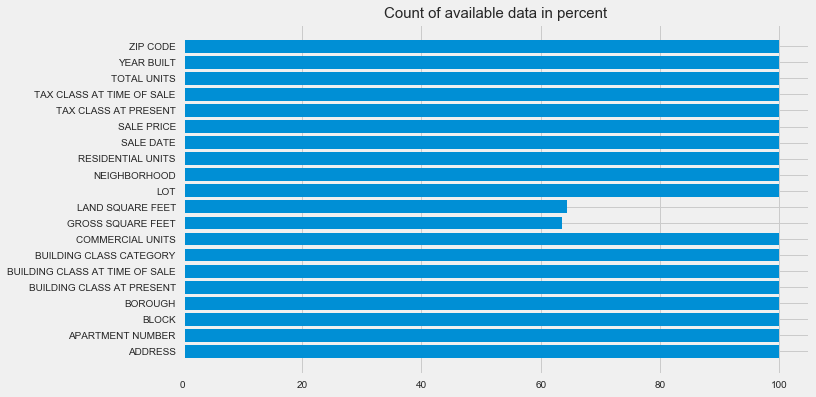

In [23]:
#Plot number of available data per variable
plt.figure(figsize=(10,6))
plt.barh(variables, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

## 2.2) Independent Variables Inspection 

I have already looked at each variable in more detail and only show the ones I am going to keep for the model. Currently I have removed all the NULL and outlier data of **SQUARE FEET** and **TOTAL UNITS** but in a future iteration I will try to impute some data points to keep as much as data as possible.

**SQUARE FEET**

I need to get rid of the NULL values and a few outliers.

In [24]:
# Removes all NULL values
data = data[data['LAND SQUARE FEET'].notnull()] 
data = data[data['GROSS SQUARE FEET'].notnull()] 

In [25]:
# Keeps properties with fewer than 20,000 Square Feet, which is about 2,000 Square Metres
data = data[data['GROSS SQUARE FEET'] < 20000]
data = data[data['LAND SQUARE FEET'] < 20000]

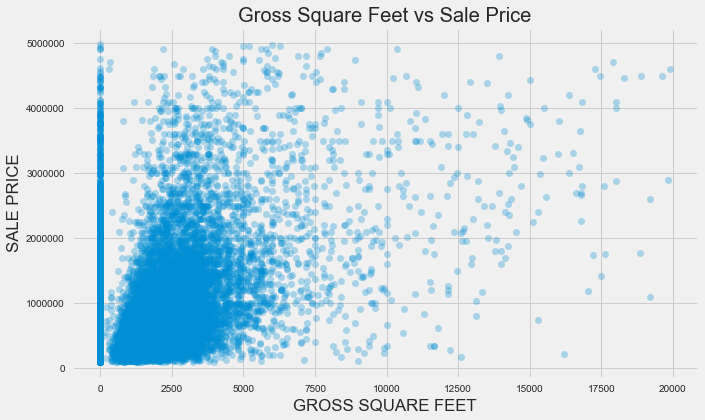

In [26]:
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})
plt.title('Gross Square Feet vs Sale Price')
plt.show()

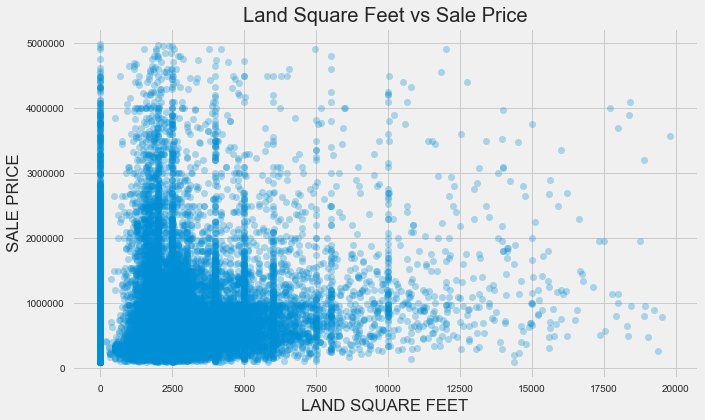

In [27]:
plt.figure(figsize=(10,6))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.3})
plt.title('Land Square Feet vs Sale Price')
plt.show()

**Total Units**

I am deleting the outliers with very large numbers of **TOTAL UNITS** and those with 0 units. Those are only a handful of observations though. In addition, I get rid of the observations the sum of **COMMERCIAL UNITS** and **RESIDENTIAL UNITS** doesn't match **TOTAL UNITS**.

In [28]:
# Only a handful of properties with 0 total units are remaining and they will now be deleted
data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] < 50)] 

In [29]:
#Remove data where commercial + residential doesn't equal total units
data = data[data['TOTAL UNITS'] == data['COMMERCIAL UNITS'] + data['RESIDENTIAL UNITS']]

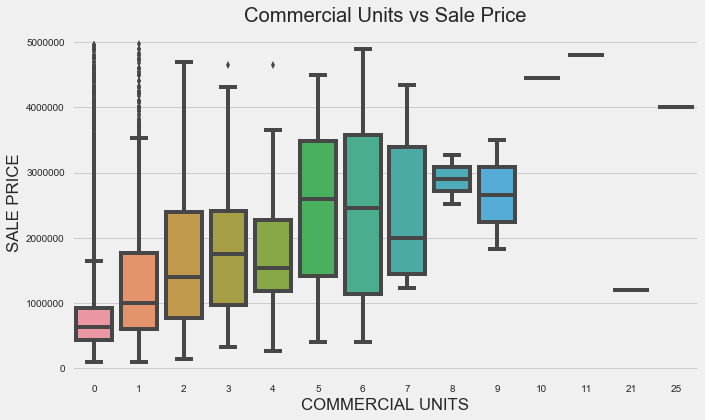

In [30]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=data)
plt.title('Commercial Units vs Sale Price')
plt.show()

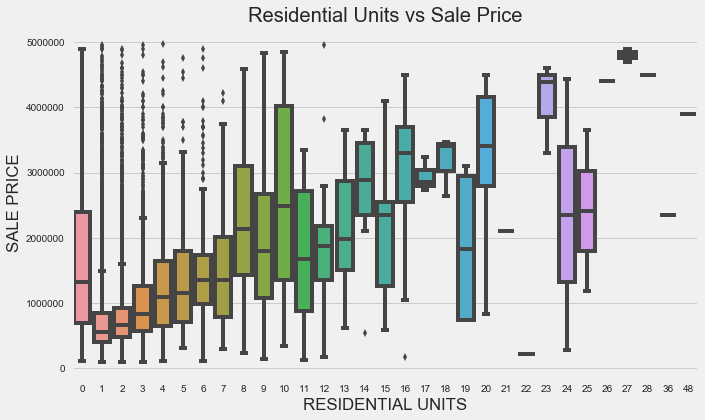

In [31]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=data)
plt.title('Residential Units vs Sale Price')
plt.show()

**YEAR BUILT**

Next one up is YEAR BUILT. There seem to be some buildings that were built in the year 0, which can't be correct. Let's remove those.

In [32]:
data = data[data['YEAR BUILT'] > 0]

What does the plot look like now? OK, that's a lot more realistic.

However, **YEAR BUILT** isn't quite the variable we are looking for. What is more interesting is the **BUILDING AGE**. Both contain similar information, the second is however a bit more practical. So, let's create it.

In [33]:
data['BUILDING AGE'] = 2017 - data['YEAR BUILT']

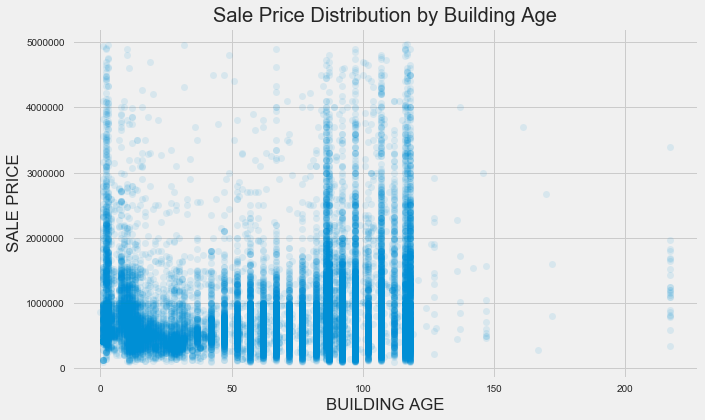

In [34]:
plt.figure(figsize=(10,6))
sns.regplot(x='BUILDING AGE', y='SALE PRICE', data=data, fit_reg=False, scatter_kws={'alpha':0.1})
plt.title('Sale Price Distribution by Building Age')
plt.show()

**BOROUGH**

This is all in good shape and no surpises here.

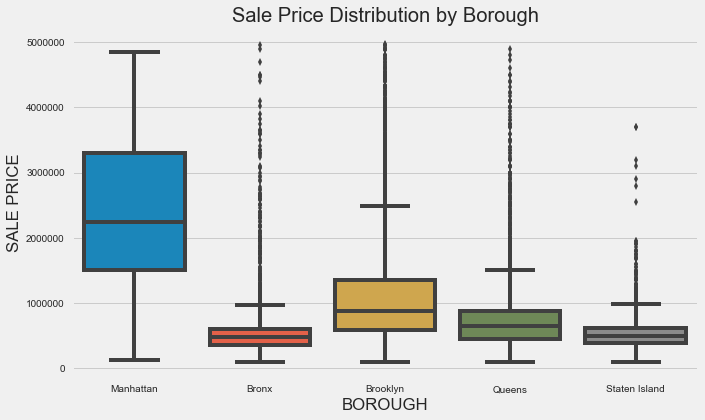

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(x='BOROUGH', y='SALE PRICE', data=data)
plt.title('Sale Price Distribution by Borough')
plt.show()

**Building Class Category**

Some of the categories could potentially be merged in a future iteration.

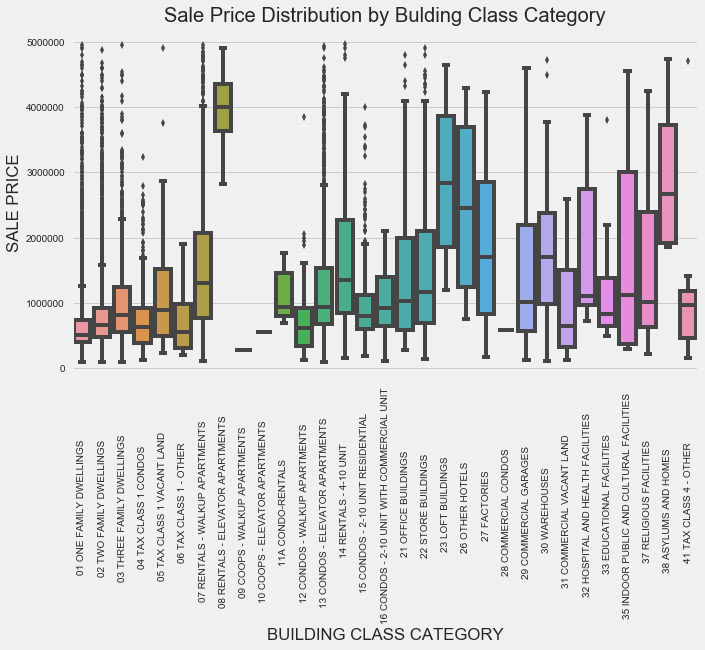

In [36]:
plt.figure(figsize=(10,6))
order = sorted(data['BUILDING CLASS CATEGORY'].unique())
sns.boxplot(x='BUILDING CLASS CATEGORY', y='SALE PRICE', data=data, order=order)
plt.xticks(rotation=90)
plt.title('Sale Price Distribution by Bulding Class Category')
plt.show()

**More Data Visualisations**

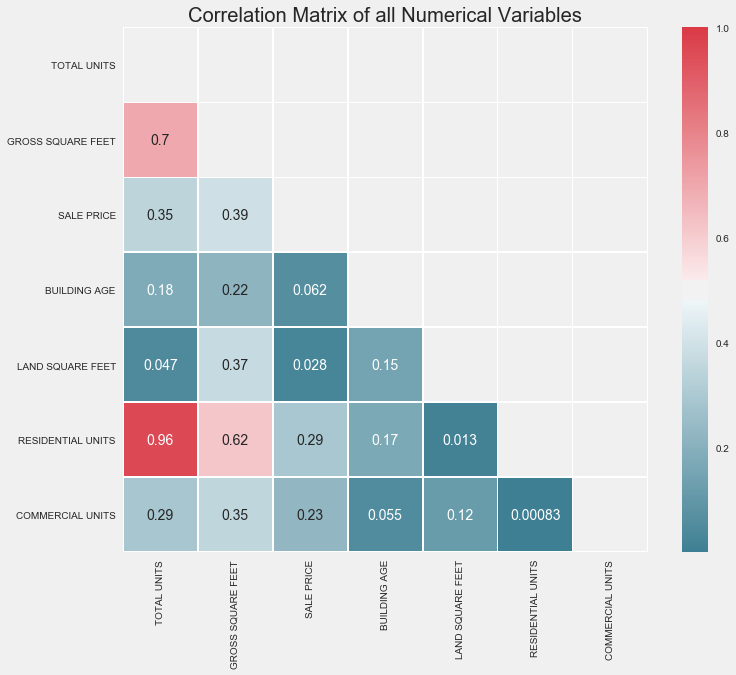

In [37]:
# Correlation Matrix

# Compute the correlation matrix
d= data[['TOTAL UNITS','GROSS SQUARE FEET','SALE PRICE', 'BUILDING AGE', 'LAND SQUARE FEET', 'RESIDENTIAL UNITS', 
         'COMMERCIAL UNITS']]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=True, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

# 3) Modelling

## 3.1) Data Preparation

scikit works best with normalized data, i.e. data that has a mean around 0 and a distribution around that. In the next section I will normalise/standardise the data and also take the log in order to get rid of the skewness and to allow for a more normal distribution.

But first I get all the relevant variables and one-hot encode the categrical variables, which is necessary for scikit to work. The numerical variables don't need one-hot encoding but will have to be normalised.


In [38]:
#Choose only the variables I want to use in the model
columns = ['BOROUGH', 'BUILDING CLASS CATEGORY', 'COMMERCIAL UNITS','GROSS SQUARE FEET',
       'SALE PRICE', 'BUILDING AGE', 'LAND SQUARE FEET', 'RESIDENTIAL UNITS']
data_model = data.loc[:,columns]

In [39]:
#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY']

# For each categorical column, find the unique number of categories. This tells us how many columns we are adding to the dataset.
longest_str = max(one_hot_features, key=len)
total_num_unique_categorical = 0
for feature in one_hot_features:
    num_unique = len(data[feature].unique())
    print('{col:<{fill_col}} : {num:d} unique categorical values.'.format(col=feature, 
                                                                          fill_col=len(longest_str),
                                                                          num=num_unique))
    total_num_unique_categorical += num_unique
print('{total:d} columns will be added during one-hot encoding.'.format(total=total_num_unique_categorical))

BOROUGH                 : 5 unique categorical values.
BUILDING CLASS CATEGORY : 31 unique categorical values.
36 columns will be added during one-hot encoding.


In [40]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data_model[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29638 entries, 3 to 84545
Data columns (total 36 columns):
BOROUGH_Bronx                                                           29638 non-null uint8
BOROUGH_Brooklyn                                                        29638 non-null uint8
BOROUGH_Manhattan                                                       29638 non-null uint8
BOROUGH_Queens                                                          29638 non-null uint8
BOROUGH_Staten Island                                                   29638 non-null uint8
BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                         29638 non-null uint8
BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                         29638 non-null uint8
BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                       29638 non-null uint8
BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS                           29638 non-null uint8
BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND    

In [41]:
#Delete the old columns...
data_model = data_model.drop(one_hot_features, axis=1)

#...and add the new one-hot encoded variables
data_model = pd.concat([data_model, one_hot_encoded], axis=1)
data_model.head()

,COMMERCIAL UNITS,GROSS SQUARE FEET,SALE PRICE,BUILDING AGE,LAND SQUARE FEET,RESIDENTIAL UNITS,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER
3,0,6794.0,3936272.0,104,2272.0,10,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,4226.0,3192840.0,97,1750.0,8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
172,1,3360.0,3300000.0,107,1520.0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174,1,3713.0,4750000.0,107,1779.0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
195,1,3586.0,3700000.0,118,1218.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


**Transforming the dependent variable SALE PRICE**

This is what SALE PRICE looks before the transformation...

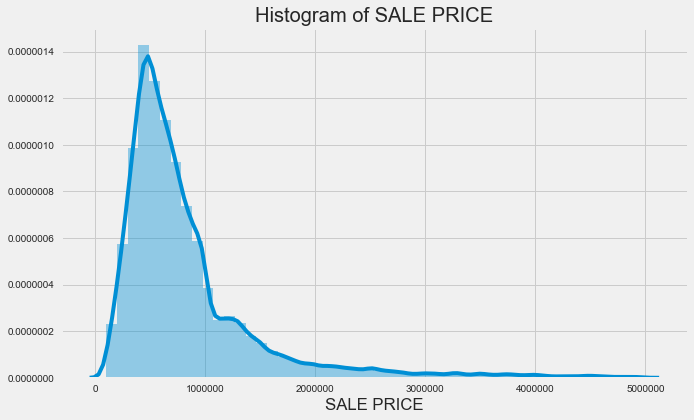

In [42]:
plt.figure(figsize=(10,6))
sns.distplot(data_model['SALE PRICE'])
plt.title('Histogram of SALE PRICE')
plt.show()

In [43]:
# Take the log and normalise
data_model['SALE PRICE'] = StandardScaler().fit_transform(np.log(data_model['SALE PRICE']).reshape(-1,1))

...and  this what it looks after

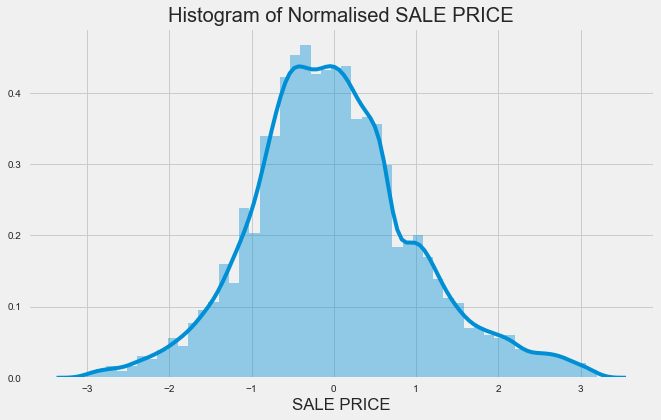

In [44]:
plt.figure(figsize=(10,6))
sns.distplot(data_model['SALE PRICE'])
plt.title('Histogram of Normalised SALE PRICE')
plt.show()

**Transforming the independent variables**

Some of the variables contain zeroes, which is why I need to add 1 so that I can take the log before normalising it - you can see that in the table below. Using the log allows me to get rid of the skew in the data and have a more normal distribution. The reason why I need to add 1 is because I can't take the log of 0 - it is not defined. The log of 1 however is.

In [45]:
data_model.describe()

,COMMERCIAL UNITS,GROSS SQUARE FEET,SALE PRICE,BUILDING AGE,LAND SQUARE FEET,RESIDENTIAL UNITS,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER
count,29638.000000,29638.000000,2.963800e+04,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000,29638.000000
mean,0.086949,1930.882347,2.116275e-15,70.616135,2723.698326,1.727175,0.113031,0.364498,0.009414,0.351542,0.161516,0.415919,0.321074,0.075477,0.012416,0.000810,0.000236,0.044369,0.000236,0.000034,0.000034,0.000270,0.007996,0.060632,0.009582,0.022167,0.000405,0.003846,0.011472,0.000135,0.000135,0.002092,0.000034,0.004251,0.003610,0.000169,0.000304,0.000405,0.000270,0.001215,0.000135,0.000270
std,0.455198,1524.886820,1.000017e+00,34.974586,1926.963113,1.518719,0.316636,0.481297,0.096568,0.477460,0.368012,0.492888,0.466897,0.264165,0.110737,0.028445,0.015367,0.205916,0.015367,0.005809,0.005809,0.016427,0.089066,0.238657,0.097421,0.147231,0.020118,0.061901,0.106492,0.011617,0.011617,0.045690,0.005809,0.065064,0.059978,0.012988,0.017424,0.020118,0.016427,0.034831,0.011617,0.016427
min,0.000000,0.000000,-3.013746e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1216.000000,-6.303558e-01,52.000000,1832.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1680.000000,-5.826635e-02,82.000000,2417.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

**UNITS**

In [46]:
# Add 1 to Units
data_model['COMMERCIAL UNITS'] = data_model['COMMERCIAL UNITS'] + 1
data_model['RESIDENTIAL UNITS'] = data_model['RESIDENTIAL UNITS'] + 1

# Take the log and standardise
data_model['COMMERCIAL UNITS'] = StandardScaler().fit_transform(np.log(data_model['COMMERCIAL UNITS']).reshape(-1,1))
data_model['RESIDENTIAL UNITS'] = StandardScaler().fit_transform(np.log(data_model['RESIDENTIAL UNITS']).reshape(-1,1))

**SQUARE FEET**

In [47]:
# Add 1 to Units
data_model['GROSS SQUARE FEET'] = data_model['GROSS SQUARE FEET'] + 1
data_model['LAND SQUARE FEET'] = data_model['LAND SQUARE FEET'] + 1

# Take the log and standardise
data_model['GROSS SQUARE FEET'] = StandardScaler().fit_transform(np.log(data_model['GROSS SQUARE FEET']).reshape(-1,1))
data_model['LAND SQUARE FEET'] = StandardScaler().fit_transform(np.log(data_model['LAND SQUARE FEET']).reshape(-1,1))

**BUILDING AGE**

In [48]:
# Add 1 to BUILDING AGE
data_model['BUILDING AGE'] = data_model['BUILDING AGE'] + 1

# Take the log and standardise
data_model['BUILDING AGE'] = StandardScaler().fit_transform(np.log(data_model['BUILDING AGE']).reshape(-1,1))

## 3.2) Split into Training/Testing Data

The step is necessary to ensure that the model is flexible and general enough so that can predict accurately unseen or new data. I train the model with the training data and then check how good it performs on the unseen testing data.

In [83]:
#Split data into training and testing set with 80% of the data going into training
training, testing = train_test_split(data_model, test_size=0.2, random_state=1)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(data_model.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 29638; training sample size = 23710, testing sample size = 5928


In [84]:
#X are the variables/features that help predict y, which tells us whether an employee left or stayed. This is done for both 
#training and testing
df_train_s = training.loc[:,data_model.columns]
X_train_s = df_train_s.drop(['SALE PRICE'], axis=1)
y_train_s = df_train_s.loc[:, ['SALE PRICE']]

df_test_s = testing.loc[:,data_model.columns]
X_test_s = df_test_s.drop(['SALE PRICE'], axis=1)
y_test_s = df_test_s.loc[:, ['SALE PRICE']]

## 3.3) Running the Different Models

Finally, the moment we have all been waiting for. I will now test a few different models to see which one performs best. In a next iteration I will also fine tune these to get an even better result.

I will use

1) **Linear Regression**

2) **Random Forest Regression**

3) **Ridge Regression**

4) **and ElasticNet**

**1) Linear Regression**

In [85]:
# Create the regressor: linreg
linreg = LinearRegression()

# Fit the regressor to the training data
linreg.fit(X_train_s, y_train_s)

# Predict the labels of the test set: y_pred
y_pred_s = linreg.predict(X_test_s)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores_linreg = cross_val_score(linreg, X_train_s, y_train_s, cv=5)

In [86]:
print("R^2: {}".format(linreg.score(X_test_s, y_test_s)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_s))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_linreg)))
# Print the 5-fold cross-validation scores
print(cv_scores_linreg)

R^2: 0.3650334302674038
Root Mean Squared Error: 0.7997379592817492
Average 5-Fold CV Score: 0.35255124624872514
[ 0.37013376  0.36115102  0.3187191   0.34596187  0.36679048]


**2) Random Forest**

In [87]:
rf_reg = RandomForestRegressor(n_estimators =100, 
                               random_state=1,
                              max_depth=10)

rf_reg.fit(X_train_s, y_train_s)

y_pred_s_rf = rf_reg.predict(X_test_s)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores_rf = cross_val_score(rf_reg, X_train_s, y_train_s, cv=5)

In [88]:
print("R^2: {}".format(rf_reg.score(X_test_s, y_test_s)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_s_rf))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_rf)))
# Print the 5-fold cross-validation scores
print(cv_scores_rf)

R^2: 0.46962246260132523
Root Mean Squared Error: 0.7309115773681705
Average 5-Fold CV Score: 0.4598044209420237
[ 0.46674626  0.47436208  0.4275897   0.46080101  0.46952306]


Feature Importance of Random Forest

In [55]:
importance = pd.DataFrame(list(zip(X_train_s.columns, np.transpose(rf_reg.feature_importances_))) \
            ).sort_values(1, ascending=False)
importance

,0,1
1,GROSS SQUARE FEET,0.431741
6,BOROUGH_Brooklyn,0.141722
2,BUILDING AGE,0.112455
3,LAND SQUARE FEET,0.100064
5,BOROUGH_Bronx,0.057898
8,BOROUGH_Queens,0.039851
22,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR A...,0.029152
4,RESIDENTIAL UNITS,0.020457
7,BOROUGH_Manhattan,0.018672
9,BOROUGH_Staten Island,0.014954


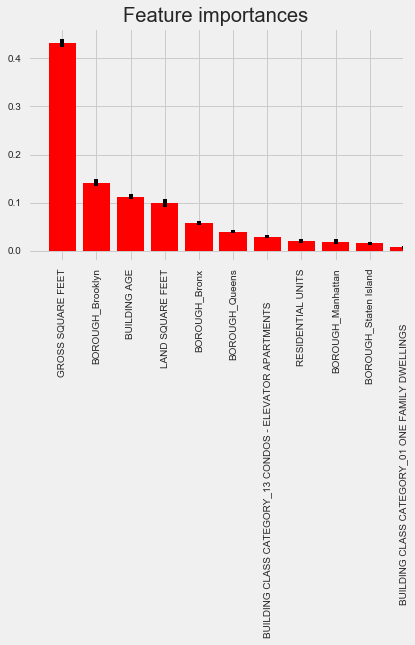

In [56]:
importances = rf_reg.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_s.shape[1]), importances[indices],  
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_s.shape[1]),X_train_s.columns[indices], rotation=90)
#plt.xlim([-1, X_train_s.shape[1]])
plt.xlim([-1, 10])
plt.show()

**3) Ridge Regression**

In [57]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

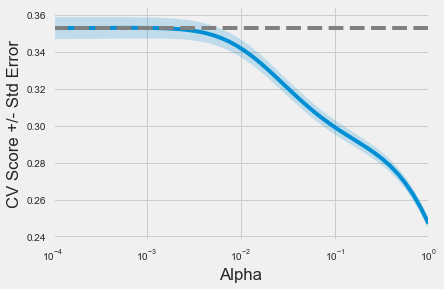

In [58]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train_s, y_train_s, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [59]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.01, normalize=True)

#Fit the model
ridge.fit(X_train_s, y_train_s)

#Predict
y_pred_s_ridge = ridge.predict(X_test_s)

# Perform 5-fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge, X_train_s, y_train_s, cv=5)


In [60]:
print("R^2: {}".format(ridge.score(X_test_s, y_test_s)))
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred_s_ridge))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 5-Fold CV Score: {}".format(np.mean(ridge_cv)))
# Print the 5-fold cross-validation scores
print(ridge_cv)

R^2: 0.3523035334356721
Root Mean Squared Error: 0.8158115478900654
Average 5-Fold CV Score: 0.3418700139000195
[ 0.34620226  0.36076913  0.32985064  0.34248812  0.33003992]


**4) ElasticNet and GridSearch**

In [61]:
# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train_s, y_train_s)

# Predict on the test set and compute metrics
y_pred_elas = gm_cv.predict(X_test_s)
r2 = gm_cv.score(X_test_s, y_test_s)
mse = mean_squared_error(y_test_s, y_pred_elas)


In [62]:
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.1426750882209621
Tuned ElasticNet MSE: 0.8809547724719723


# 4) Conclusion and Next Steps

1) An untuned Random Forest Regression managed to get a R2 of 0.40, which is certainly not great but maybe not bad given the limited amount of data available. **SQUARE FEET**, **BUILDING AGE**, and **BOROUGH** were the most important features determining the **SALE PRICE**.

2) We only used 30k observations out of a potential of 70k. Remember that there were a fair amount of NULL **SALE PRICE** observations and duplicates etc. So the original 85k don't count. In a next iteration I will therefore explore the possibilities to impute the **SQUARE FEET** data because I deleted a lot here. The same is true for **UNITS** data.

3) Instead of throwing outlier **SALE PRICE** data I will try to use clustering to classify properties,w hich would allow me to keep the outlier data - maybe. 